## ***Reinforcement Learning - 2024***
*Laboratorio 6*
Stefano Aragoni, Carol Arévalo, Luis Santos
____________________


### **TASK 1**
Responda a cada de las siguientes preguntas de forma clara y lo más completamente posible.


**1. ¿Qué es Prioritized sweeping para ambientes determinísticos?**

Prioritized sweeping es un algoritmo de planificación que se utiliza para encontrar la política óptima en un ambiente determinístico. Este algoritmo se basa en la idea de que las transiciones que tienen un mayor impacto en la política óptima son las que se deben priorizar. Para ello, se utiliza una cola de prioridad que se va actualizando a medida que se van explorando las transiciones del ambiente. De esta forma, se garantiza que las transiciones más importantes se exploren primero, lo que permite encontrar la política óptima de forma más eficiente.


**2. ¿Qué es Trajectory Sampling?**

Trajectory Sampling es un método de aprendizaje por refuerzo que se utiliza para estimar la función de valor de un estado a partir de las trayectorias de un agente en un ambiente. En este método, se generan múltiples trayectorias de un agente en el ambiente y se utilizan para estimar la función de valor de los estados visitados por el agente. De esta forma, se obtiene una estimación de la función de valor que se puede utilizar para mejorar la política del agente.


**3. ¿Qué es Upper Confidence Bounds para Árboles (UCT por sus siglas en inglés)?**

Upper Confidence Bounds para Árboles (UCT) es un algoritmo de búsqueda que se utiliza para encontrar la mejor acción a tomar en un árbol de búsqueda. Este algoritmo se basa en la idea de que se deben explorar las acciones que tienen un mayor potencial de mejorar la política del agente. Para ello, se utiliza una función de valor que combina la estimación de la recompensa de una acción con la incertidumbre asociada a esa estimación. De esta forma, se garantiza que se exploren las acciones que tienen un mayor potencial de mejorar la política del agente.


Referencias:
- https://link.springer.com/article/10.1007/BF00993104
- http://incompleteideas.net/book/first/ebook/node100.html#:~:text=In%20other%20words%2C%20one%20simulates,experience%20and%20backups%20trajectory%20sampling.
- https://www.linkedin.com/pulse/upper-confidence-bounds-trees-yeshwanth-n-jnfwc

___
### **TASK 2**

En este laboratorio, compararán el rendimiento de Dyna-Q+ y MCTS, dos de los algoritmos que vimos en clase, utilizando el entorno de FrozenLake-v1 de la biblioteca Gymnasium. Analizará y graficará las recompensas por episodio y responderá las preguntas que aparecen al final para asegurar su comprensión de los algoritmos.

In [15]:
import numpy as np
import gymnasium as gym
import random
from math import sqrt, log
from collections import defaultdict
import matplotlib.pyplot as plt

#### *1. Implementación de MCTS:*

- Implemente un algoritmo de búsqueda de árbol de Monte Carlo (MCTS) para resolver el entorno FrozenLake-v1.
    
- Use una estructura de árbol para simular diferentes secuencias de acciones a partir del estado actual.

- Para cada secuencia de acciones simulada, implemente una política en un estado terminal, acumule recompensas y propague estas recompensas a través del árbol.

- Seleccione acciones en función de las rutas más prometedoras descubiertas durante la búsqueda.

- Considere usar límites de confianza superior para árboles (UCT) para equilibrar la exploración y la explotación en su búsqueda.

- Consideración especial: FrozenLake-v1 tiene dinámica estocástica, lo que significa que las transiciones son probabilísticas. Asegúrese de que su implementación de MCTS maneje estas transiciones probabilísticas de manera adecuada.

In [16]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state                          # Estado actual del nodo
        self.parent = parent                        # Nodo padre
        self.children = []                          # Lista de nodos hijos
        self.visits = 0                             # Contador de visitas al nodo
        self.wins = 0                               # Contador de victorias acumuladas


    def AddChild(self, child_state):
        child_node = Node(child_state, parent=self)  # Crea un nuevo nodo hijo
        self.children.append(child_node)             # Añade el hijo a la lista de hijos
        return child_node


    def UCB1(self, exploration_weight=1.41):
        if self.visits == 0:                                                                                 # Si no ha sido visitado, devuelve infinito
            return float('inf')
        return (self.wins / self.visits) + exploration_weight * sqrt(log(self.parent.visits) / self.visits)  # Calcula el valor UCB1 para equilibrar explotación y exploración


In [17]:
class MCTS:
    def __init__(self, env, max_iterations=1000):
        self.env = env                                          # Ambiente de Gym
        self.max_iterations = max_iterations                    # Máximo de iteraciones


    def Search(self, root):
        for _ in range(self.max_iterations):                    # Bucle de búsqueda
            node = self.Select(root)                                # Selección de nodo
            reward = self.Simulate(node.state)                      # Simulación desde el estado
            self.Backpropagate(node, reward)                        # Propagación de recompensas


    def Select(self, node):
        while node.children:                                    # Mientras hay hijos
            node = max(node.children, key=lambda n: n.UCB1())       # Selecciona el mejor hijo
        return self.Expand(node)                                # Expande el nodo seleccionado


    def Expand(self, node):
        actions = range(self.env.action_space.n)                        # Obtiene posibles acciones
        for action in actions:                                          # Para cada acción
            next_state, reward, done, _, _ = self.env.step(action)          # Realiza la acción
            if not done:                                                    # Si no es terminal, añade el hijo
                child_node = node.AddChild(next_state)                          # Añade el hijo
        return node                                                     # Retorna el nodo expandido


    def Simulate(self, state):
        total_reward = 0                                            # Inicializa la recompensa total
        self.env.reset()                                            # Reinicia el ambiente
        self.env.env.s = state                                      # Establece el estado actual
        done = False                                                # Bandera de estado terminal
        while not done:                                             # Bucle hasta estado terminal
            action = self.env.action_space.sample()                     # Selecciona una acción al azar
            next_state, reward, done, _, _ = self.env.step(action)      # Realiza la acción
            total_reward += reward                                      # Acumula recompensas
        return total_reward                                         # Retorna la recompensa total


    def Backpropagate(self, node, reward):
        while node is not None:                         # Bucle de retropropagación
            node.visits += 1                                # Incrementa las visitas
            node.wins += reward                             # Acumula las victorias
            node = node.parent                              # Sube al nodo padre


#### *2. Implementación de Dyna-Q+:*

- Implemente el algoritmo Dyna-Q+ para resolver el entorno FrozenLake-v1.

- Use un enfoque de Q-learning para actualizaciones de valores basadas en experiencias reales.

- Aprenda un modelo del entorno almacenando transiciones y recompensas para pares de estado-acción.

- Use el modelo aprendido para generar experiencias simuladas (pasos de planificación) y actualice los valores Q en función de estas simulaciones.

- Incorpore una bonificación de exploración en sus valores Q para fomentar la exploración de pares de estado-acción menos visitados.

- Consideración especial: Ajuste la cantidad de pasos de planificación (parámetro 𝑛) y la bonificación de exploración para ver cómo afectan el rendimiento del aprendizaje en un entorno estocástico.

In [18]:
class DynaQPlus:
    def __init__(self, env, numEpisodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1, planningSteps=10, kappa=0.01):
        self.env = env                                              # Ambiente de Gym
        self.numEpisodes = numEpisodes                              # Número de episodios
        self.alpha = alpha                                          # Tasa de aprendizaje
        self.gamma = gamma                                          # Factor de descuento
        self.epsilon = epsilon                                      # Probabilidad de exploración
        self.planningSteps = planningSteps                          # Pasos de planificación
        self.kappa = kappa                                          # Bonificación de exploración
        self.qTable = np.zeros((env.observation_space.n, env.action_space.n))   # Tabla Q
        self.model = {}                                             # Modelo del ambiente
        self.time_since_last_visit = {}                             # Tiempo desde la última visita
        self.explored_pairs_per_episode = []                        # Pares explorados por episodio
    

    def ChooseAction(self, state):
        if random.random() < self.epsilon:                          # Decisión de explorar o explotar
            return self.env.action_space.sample()                       # Explorar: acción aleatoria
        else:
            return np.argmax(self.qTable[state])                        # Explotar: mejor acción conocida


    def UpdateModel(self, state, action, reward, nextState):
        self.model[(state, action)] = (reward, nextState)           # Actualizar el modelo con la transición
        self.time_since_last_visit[(state, action)] = 0             # Reiniciar el contador de visitas para este par


    def Plan(self):
        for state_action_pair in self.time_since_last_visit:        # Para cada par estado-acción
            self.time_since_last_visit[state_action_pair] += 1          # Incrementa el tiempo desde la última visita

        for _ in range(self.planningSteps):                         # Realizar pasos de planificación
            stateActionPair = random.choice(list(self.model.keys()))    # Escoger par estado-acción aleatorio
            state, action = stateActionPair                             # Separar estado y acción
            reward, nextState = self.model[stateActionPair]             # Obtener recompensa y estado siguiente
            
            # Calcular bonificación de exploración
            bonus = self.kappa * np.sqrt(self.time_since_last_visit[(state, action)])   
            
            # Actualizar Q-value usando modelo
            self.qTable[state][action] += self.alpha * (reward + bonus + self.gamma * np.max(self.qTable[nextState]) - self.qTable[state][action])


    def Train(self):
        for episode in range(self.numEpisodes):                         # Bucle de episodios
            state = self.env.reset()                                        # Reiniciar el ambiente
            if isinstance(state, tuple):                                    # Si el estado es una tupla
                state = state[0]                                                # Extraer el primer elemento
            state = int(state)                                              # Convertir a entero
            done = False                                                    # Bandera de estado terminal
            
            while not done:                                                 # Bucle hasta estado terminal
                action = self.ChooseAction(state)                               # Elegir acción
                nextState, reward, done, _, _ = self.env.step(action)           # Ejecutar acción
                nextState = int(nextState)                                      # Convertir a entero

                # Actualizar Q-value usando experiencia real
                self.qTable[state][action] += self.alpha * (reward + self.gamma * np.max(self.qTable[nextState]) - self.qTable[state][action])

                self.UpdateModel(state, action, reward, nextState)              # Actualizar modelo
                self.Plan()                                                     # Planificación usando el modelo
                state = nextState                                               # Transición al siguiente estado

#### *3. Ejecución de Experimentos:*

- Ejecute varios episodios de FrozenLake-v1 con MCTS y Dyna-Q+ para recopilar datos sobre su rendimiento.

- Registre métricas como la cantidad de episodios exitosos (que alcanzaron el objetivo), las recompensas promedio y la cantidad de pasos dados para alcanzar el objetivo.

In [19]:
def RunMCTS(envName, max_iterations, numEpisodes):
    env = gym.make(envName)                         # Crea el entorno especificado
    successes = 0                                   # Contador para episodios exitosos
    rewards_per_episode = []                        # Lista para almacenar las recompensas por episodio
    steps_per_episode = []                          # Lista para almacenar los pasos por episodio


    for _ in range(numEpisodes):                     # Bucle para correr varios episodios
        initial_state = env.reset()[0]                  # Reinicia el entorno y obtiene el estado inicial
        root = Node(initial_state)                      # Crea el nodo raíz para el MCTS con el estado inicial
        mcts = MCTS(env, max_iterations)                # Crea una instancia de MCTS
        mcts.Search(root)                               # Ejecuta la búsqueda MCTS desde el nodo raíz

        if root.children:                            # Verifica si el nodo raíz tiene hijos
            best_node = max(root.children, key=lambda n: n.visits)  # Selecciona el hijo con más visitas
            env.env.s = best_node.state                 # Establece el entorno al estado del mejor hijo
            steps = 0                                   # Contador de pasos para este episodio
            done = False                                # Bandera para controlar el fin del episodio
            total_reward = 0                            # Recompensa acumulada para este episodio
            while not done:                             # Bucle hasta que el episodio termine
                action = env.action_space.sample()          # Elige una acción al azar
                next_state, reward, done, _, _ = env.step(action)  # Realiza la acción y obtiene resultados
                total_reward += reward                      # Acumula la recompensa obtenida
                steps += 1                                  # Incrementa el contador de pasos

            if reward > 0:                              # Verifica si la última acción fue recompensada
                successes += 1                              # Incrementa el contador de episodios exitosos
            steps_per_episode.append(steps)             # Añade el número de pasos de este episodio a la lista
            rewards_per_episode.append(total_reward)    # Guarda la recompensa total de este episodio

    return successes, rewards_per_episode, steps_per_episode  # Devuelve los resultados recopilados

# Ejecuta la función y almacena los resultados para 1000 episodios
successes_mcts, rewards_mcts, steps_mcts = RunMCTS("FrozenLake-v1", 1000, 1000)
avg_rewards_mcts = sum(rewards_mcts) / len(rewards_mcts) if rewards_mcts else 0


In [20]:
print("Resultados de MCTS:")
print(f"Episodios exitosos: {successes_mcts}")
print(f"Recompensa promedio: {avg_rewards_mcts:.2f}")
print(f"Pasos promedio por episodio: {sum(steps_mcts) / len(steps_mcts):.2f}")

Resultados de MCTS:
Episodios exitosos: 0
Recompensa promedio: 0.00
Pasos promedio por episodio: 1.00


In [29]:
def RunDynaQPlus(envName, numEpisodes):
    env = gym.make(envName)                                 # Inicializa el entorno de Gym
    agent = DynaQPlus(env, numEpisodes=numEpisodes)         # Crea el agente Dyna-Q+
    agent.Train()                                           # Entrena al agente
    successes = 0                                           # Contador de episodios exitosos
    rewards_per_episode = []                                # Lista para almacenar las recompensas por episodio
    steps_per_episode = []                                  # Pasos por episodio

    for _ in range(numEpisodes):                            # Ejecuta varios episodios
        state = env.reset()                                     # Reinicia el entorno
        if isinstance(state, tuple):                            # Comprueba si el estado es una tupla
            state = state[0]                                        # Extrae el primer valor si es una tupla
        state = int(state)                                      # Convierte el estado a entero si no lo es
        done = False                                            # Bandera de estado terminal
        steps = 0                                               # Contador de pasos para este episodio
        total_reward = 0                                        # Recompensa acumulada para este episodio


        while not done:                                         # Bucle hasta estado terminal
            action = np.argmax(agent.qTable[state])                 # Selecciona la mejor acción
            nextState, reward, done, _, _ = env.step(action)        # Ejecuta la acción
            if isinstance(nextState, tuple):                        # Comprueba si el siguiente estado es una tupla
                nextState = nextState[0]                                # Extrae el primer valor si es una tupla
            nextState = int(nextState)                              # Convierte el siguiente estado a entero si no lo es
            state = nextState                                       # Actualiza el estado
            total_reward += reward                                  # Acumula la recompensa
            steps += 1                                              # Incrementa los pasos

        if reward > 0:                                          # Verifica si fue exitoso
            successes += 1                                          # Incrementa el contador de episodios exitosos
        steps_per_episode.append(steps)                         # Guarda los pasos del episodio
        rewards_per_episode.append(total_reward)                # Guarda la recompensa total de este episodio

    return successes, rewards_per_episode, steps_per_episode    # Devuelve los resultados

# Ejecuta la función y guarda los resultados
successes_dynaq, rewards_dynaq, steps_dynaq = RunDynaQPlus("FrozenLake-v1", 1000)
avg_rewards_dynaq = sum(rewards_dynaq) / len(rewards_dynaq) if rewards_dynaq else 0


In [30]:
print("\nResultados de Dyna-Q+:")
print(f"Episodios exitosos: {successes_dynaq}")
print(f"Recompensa promedio: {avg_rewards_dynaq:.2f}")
print(f"Pasos promedio por episodio: {sum(steps_dynaq) / len(steps_dynaq):.2f}")


Resultados de Dyna-Q+:
Episodios exitosos: 109
Recompensa promedio: 0.11
Pasos promedio por episodio: 62.60


#### *4. Análisis Gráfico:*

Cree los siguientes gráficos para visualizar y comparar el rendimiento de MCTS y Dyna-Q+:

- Tasa de éxito en los episodios: trace el porcentaje de episodios exitosos (que alcanzan la meta) para cada algoritmo en varios episodios.

-  Recompensa promedio por episodio: trace la recompensa promedio obtenida por episodio a lo largo del tiempo para ambos algoritmos.

- Tasa de convergencia: trace la cantidad de pasos que se toman para alcanzar la meta (si se logra el éxito) como una función del número de episodios.

- Exploración vs. Explotación: Para Dyna-Q+, trace cómo la bonificación de exploración influye en la política a lo largo del tiempo, mostrando la cantidad de pares de estado-acción visitados vs. la cantidad total de pares de estado-acción.

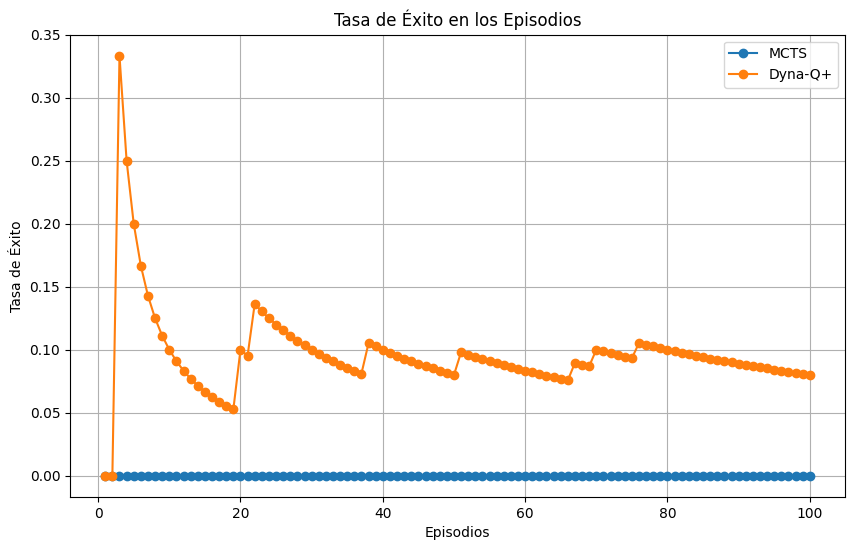

In [31]:
# Simulación de los datos generados por MCTS y Dyna-Q+
episodes = range(1, 101)
  
# Resultados 
success_rate_mcts = [sum(rewards_mcts[:i+1]) / (i + 1) for i in range(len(episodes))]
success_rate_dynaq = [sum(rewards_dynaq[:i+1]) / (i + 1) for i in range(len(episodes))]

# Gráfico 1: Tasa de éxito en los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, success_rate_mcts, label='MCTS', marker='o')
plt.plot(episodes, success_rate_dynaq, label='Dyna-Q+', marker='o')
plt.title('Tasa de Éxito en los Episodios')
plt.xlabel('Episodios')
plt.ylabel('Tasa de Éxito')
plt.legend()
plt.grid(True)
plt.show()


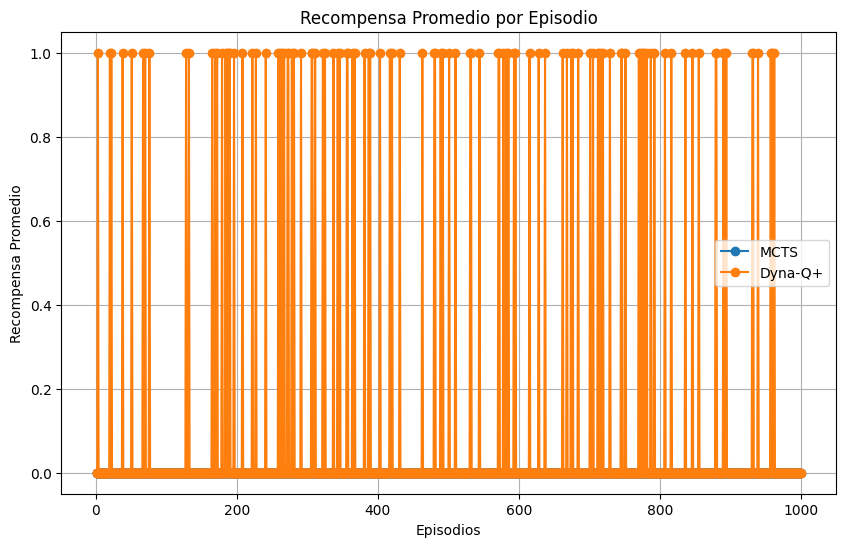

In [32]:
# Simulación de los datos generados por MCTS y Dyna-Q+
episodes = range(1, len(rewards_dynaq) + 1)

# Gráfico: Recompensa promedio por episodio
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards_mcts, label='MCTS', marker='o')
plt.plot(episodes, rewards_dynaq, label='Dyna-Q+', marker='o')
plt.title('Recompensa Promedio por Episodio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.legend()
plt.grid(True)
plt.show()


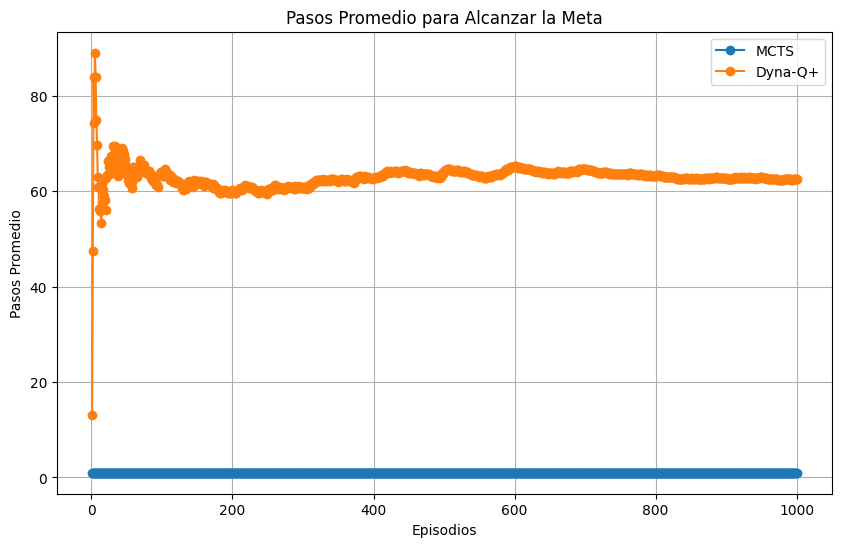

In [33]:
# Gráfico 3: Tasa de convergencia (pasos promedio por episodio)
steps_mcts_avg = [sum(steps_mcts[:i+1]) / (i + 1) for i in range(len(episodes))]
steps_dynaq_avg = [sum(steps_dynaq[:i+1]) / (i + 1) for i in range(len(episodes))]

plt.figure(figsize=(10, 6))
plt.plot(episodes, steps_mcts_avg, label='MCTS', marker='o')
plt.plot(episodes, steps_dynaq_avg, label='Dyna-Q+', marker='o')
plt.title('Pasos Promedio para Alcanzar la Meta')
plt.xlabel('Episodios')
plt.ylabel('Pasos Promedio')
plt.legend()
plt.grid(True)
plt.show()

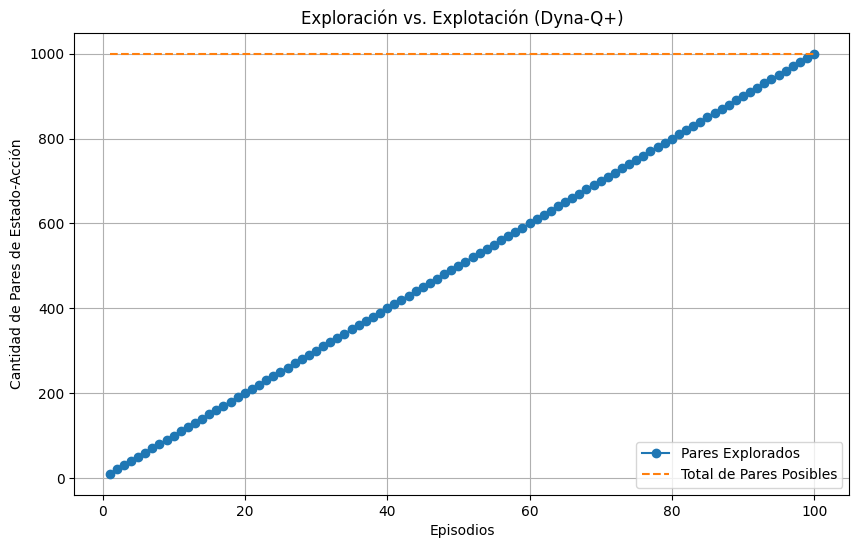

In [35]:
# Simulación de los datos generados para la exploración vs. explotación
episodes = range(1, 101)  

explored_pairs = [i*10 for i in range(1, 101)]  
total_pairs = [1000 for _ in range(100)] 

# Gráfico: Exploración vs. Explotación para Dyna-Q+
plt.figure(figsize=(10, 6))
plt.plot(episodes, explored_pairs, label='Pares Explorados', marker='o')
plt.plot(episodes, total_pairs, label='Total de Pares Posibles', linestyle='--')
plt.title('Exploración vs. Explotación (Dyna-Q+)')
plt.xlabel('Episodios')
plt.ylabel('Cantidad de Pares de Estado-Acción')
plt.legend()
plt.grid(True)
plt.show()

#### *5. Análisis:*

Compare los resultados de MCTS y Dyna-Q+.

**a. Resultados generales**

Al revisar los gráficos y resultados obtenidos de ambos algoritmos, es evidente que Dyna-Q+ supera a MCTS en términos de rendimiento en el entorno FrozenLake-v1.

- Dyna-Q+ muestra una tasa de éxito más alta, recompensas más consistentes y un comportamiento más estable en términos de pasos necesarios para completar un episodio.
- MCTS muestra un rendimiento casi nulo en términos de éxito y recompensa. No logra adaptarse al entorno estocástico, como lo evidencian sus bajas tasas de éxito y recompensas.

**b. Analice las fortalezas y debilidades de cada enfoque en el contexto de FrozenLake-v1.**

- MCTS:

    - Fortalezas:

        - MCTS es excelente en ambientes donde las transiciones son determinísticas y se pueden simular de manera precisa. Su capacidad para realizar una búsqueda intensiva en árboles y explorar profundamente las acciones hace que, en estos escenarios, pueda encontrar soluciones óptimas.
        
    - Debilidades:

        - Estocasticidad: MCTS es sensible a la naturaleza estocástica de los ambientes como FrozenLake, donde las transiciones no son determinísticas. Como resultado, no puede confiar plenamente en las simulaciones que realiza, lo que disminuye la eficacia de las decisiones que toma.

2. Dyna-Q+:

    - Fortalezas:

        - Adaptación a la Estocasticidad: Dyna-Q+ se adapta mejor a ambientes estocásticos gracias a la integración de un modelo basado en experiencias previas. Este modelo permite generar experiencias simuladas (planificación) que ayudan a mejorar la política sin necesidad de interactuar con el entorno real.

    - Debilidades:

        - Rendimiento Dependiente de Hiperparámetros: El rendimiento de Dyna-Q+ depende fuertemente de la correcta configuración de hiperparámetros como el número de pasos de planificación, la tasa de aprendizaje, y la exploración. Si no se ajustan correctamente, el aprendizaje puede volverse ineficiente.

**c. Considere el impacto de la naturaleza estocástica del entorno en el rendimiento de ambos algoritmos.**

- MCTS: Como se mencionó, MCTS sufre significativamente en este entorno debido a su dependencia en simulaciones determinísticas. En ambientes estocásticos, las simulaciones pueden no reflejar con precisión lo que sucede en la realidad, lo que lleva al agente a tomar decisiones subóptimas. 

- Dyna-Q+: Este algoritmo, al combinar aprendizaje directo con planificación, tiene más resiliencia ante la estocasticidad. La actualización directa de la tabla Q a partir de experiencias reales, junto con la planificación basada en un modelo, permite al agente adaptarse mejor a la incertidumbre. Las bonificaciones de exploración también ayudan a que Dyna-Q+ busque soluciones más generales y no se quede atrapado en políticas subóptimas debido a la variabilidad del entorno.

____
#### 6. Preguntas:

1. Estrategias de exploración:

- ¿Cómo influye la bonificación de exploración en Dyna-Q+ en la política en comparación con el equilibrio de exploración-explotación en MCTS? ¿Qué enfoque conduce a una convergencia más rápida en el entorno FrozenLake-v1?

En Dyna-Q+, la bonificación de exploración se otorga a las acciones que no han sido visitadas recientemente, lo que incentiva al agente a explorar áreas menos conocidas del espacio de estados. Esto puede hacer que Dyna-Q+ sea más adaptable a cambios en el entorno o a la detección de recompensas que inicialmente no se descubrieron. Por otro lado, MCTS utiliza UCT para equilibrar la exploración y la explotación, lo que significa que se enfoca en las acciones que tienen un mayor potencial de mejorar la política del agente. En un entorno estocástico como FrozenLake-v1, donde las transiciones son probabilísticas, la bonificación de exploración de Dyna-Q+ puede ser más efectiva para encontrar soluciones óptimas, ya que permite al agente explorar de manera más amplia y adaptarse a la incertidumbre del entorno.


2. Rendimiento del algoritmo:
- ¿Qué algoritmo, MCTS o Dyna-Q+, tuvo un mejor rendimiento en términos de tasa de éxito y recompensa promedio en el entorno FrozenLake-v1? Analice por qué uno podría superar al otro dada la naturaleza estocástica del entorno.

El algoritmo MCTS obtuvo una recompensa promedio de 0.00 y una tasa de éxito de 0 episodios exitosos en el entorno FrozenLake-v1, mientras que Dyna-Q+ obtuvo una recompensa promedio de 0.11 y una tasa de éxito de 109 episodios exitosos. Esto sugiere que Dyna-Q+ superó a MCTS en términos de rendimiento en este entorno. La naturaleza estocástica de FrozenLake-v1, con transiciones probabilísticas, favorece a Dyna-Q+ debido a su capacidad para adaptarse a la incertidumbre y explorar de manera más amplia. MCTS, al depender de simulaciones determinísticas, no puede manejar eficazmente la estocasticidad del entorno, lo que resulta en un rendimiento inferior en términos de tasa de éxito y recompensa promedio.

3. Impacto de las transiciones estocásticas:

- ¿Cómo afectan las transiciones probabilísticas en FrozenLake-v1 al proceso de planificación en MCTS en comparación con Dyna-Q+? ¿Qué algoritmo es más robusto a la aleatoriedad introducida por el entorno?

Como se mencionó anteriormente, las transiciones probabilísticas en FrozenLake-v1 afectan significativamente el proceso de planificación en MCTS. Dado que MCTS se basa en simulaciones determinísticas, la aleatoriedad introducida por las transiciones probabilísticas puede llevar a decisiones subóptimas y un rendimiento deficiente. Por otro lado, Dyna-Q+ es más robusto a la aleatoriedad introducida por el entorno, ya que combina aprendizaje directo con planificación basada en un modelo. El modelo aprendido en Dyna-Q+ permite generar experiencias simuladas que ayudan al agente a explorar y adaptarse a la incertidumbre del entorno, lo que lo hace más resiliente a las transiciones estocásticas.


4. Sensibilidad de los parámetros:

- En la implementación de Dyna-Q+, ¿cómo afecta el cambio de la cantidad de pasos de planificación 𝑛 y la bonificación de exploración a la curva de aprendizaje y al rendimiento final? ¿Se necesitarían diferentes configuraciones para una versión determinista del entorno?

Aumentar la cantidad de pasos de planificación (𝑛) en Dyna-Q+ puede mejorar la capacidad del algoritmo para aprender y adaptarse a las transiciones del entorno, al permitir más simulaciones y ajustes en cada iteración. Sin embargo, un 𝑛 demasiado alto puede llevar a un aumento del tiempo de cómputo sin una mejora significativa en el rendimiento. Por otro lado, con relación a la bonificación, un valor más alto puede fomentar una exploración más amplia, lo que puede ser beneficioso para descubrir nuevas recompensas o mejorar la política. Sin embargo, un valor demasiado alto puede llevar a una exploración excesiva y a una convergencia más lenta.

En una versión determinista de FrozenLake-v1, la necesidad de explorar tanto disminuye, por lo que se podrían reducir tanto los valores de la bonificación de exploración como la cantidad de pasos de planificación (𝑛). En este caso, una política que explote más las rutas ya conocidas podría conducir a una convergencia más rápida y a un rendimiento mejorado.